In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite2d'
run_name = 'sarsa'
data_dir = '../data/' + system_name + '/' + run_name + '/'
plot_dir = '../plots/' + system_name + '/' + run_name + '/'

## Learning of the 2d kite
- The aggregate state is the discretized attack angle
- The wind velocity is constant
- The initial angle with the ground, $\theta$, is constant
- The initial attack angle can be choosen constant or random
- The algortihm is sarsa

In [25]:
# ENVIRONMENT PARAMETERS
env_params = dict()
env_params['int_steps'] = 0.0005 # sec
env_params['ep_length'] = 200 # sec
env_params['decision_time'] = 0.05 # sec
env_params['init_theta'] = np.pi/4 # rad
env_params['init_dtheta'] = 0 # rad
# attack angles
env_params['alphas'] = [-4, 0, 4, 8, 12, 14, 16, 18, 20]
env_params['CL_alphas'] = [0.05, 0.35, 0.55, 0.75, 0.9, 1.0, 1.08, 1.1, 1.05]
env_params['CD_alphas'] = [0.001, 0.01, 0.03, 0.07, 0.1, 0.13, 0.18, 0.18, 0.21]
env_params['init_alpha'] = len(env_params['alphas'])+1 # index, if larger than len it's random
# wind
env_params['wind_type'] = 'const' # 'const' for constant, 'stream' for the stream function
env_params['v_wind_x'] = 10 # m/sec
env_params['v_wind_y'] = 0 # m/sec

# ALG PARAMETERS
alg_params = dict()
alg_params['alg_type'] = 'sarsa' # 'ac' for actor-critic, 'nac' for natural actor-critic
alg_params['gamma'] = 1.0
alg_params['n_steps'] = 8000000 # Number of training steps
print('Dynamical steps: ', alg_params['n_steps']*env_params['decision_time']/env_params['int_steps'])
print('Dynamical time, in seconds: ', alg_params['n_steps']*env_params['decision_time'])

alg_params['traj_points'] = 1000
#alg_params['init_val_path'] = data_dir + 'init_value.txt' # Value prior, comment for constant values
#alg_params['init_pol_path'] = data_dir + 'init_policy.txt' # Policy prior, comment for flat policy
alg_params['init_quals'] = env_params['v_wind_x']*env_params['ep_length']/5 # Init constant values if priors are not specified
# Learning rate
alg_params['lr0'] = 0.1
alg_params['lrc'] = 8
alg_params['lr_expn'] = 0.8
alg_params['lr_burn'] = 500
# Exploration parameter
alg_params['eps0'] = 0.1
alg_params['epsc'] = 50
alg_params['eps_expn'] = 1
alg_params['eps_burn'] = 20

Dynamical steps:  800000000.0
Dynamical time, in seconds:  400000.0


In [26]:
# WRITING THE PARAMETERS
ut.write_params(env_params, data_dir, "param_env.txt")
ut.write_params(alg_params, data_dir, "param_alg.txt")

In [27]:
# COMPILING C++ SCRIPT
comp_list = np.array(["g++", "-o", "run.exe", "run.cpp", "../lib/alg.cpp", "../lib/nac.cpp", "../lib/qalg.cpp", "../lib/eval.cpp", "../lib/utils.cpp", "../lib/wind.cpp", 
            "../lib/envs/kite.cpp", "../lib/envs/kite2d.cpp", "../lib/envs/kite3d.cpp", "-std=c++17"])
comp_str = ""
for s in comp_list: comp_str+=s+" "
print('To compile from terminal: ')
print(comp_str)

To compile from terminal: 
g++ -o run.exe run.cpp ../lib/alg.cpp ../lib/nac.cpp ../lib/qalg.cpp ../lib/eval.cpp ../lib/utils.cpp ../lib/wind.cpp ../lib/envs/kite.cpp ../lib/envs/kite2d.cpp ../lib/envs/kite3d.cpp -std=c++17 


In [28]:
import numpy as np
#v_traj = np.loadtxt(data_dir + system_name + '/' + run_name + '/value_traj.txt', dtype='float')
q_traj, s_labels, a_labels = ut.read_2d_traj(data_dir+'/quality_traj.txt')
r_traj, head = ut.read_traj(data_dir+'/return_traj.txt')

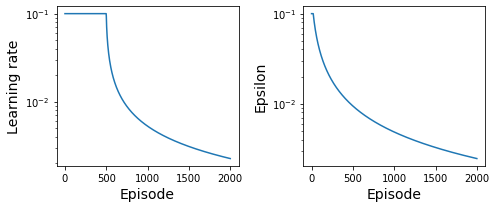

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3))

ax1.set_xlabel('Episode', fontsize=14)
ax1.set_ylabel('Learning rate', fontsize=14)
ax1.set_yscale('log')
xs = np.linspace(0, alg_params['n_steps']/env_params['ep_length']*env_params['decision_time'], alg_params['traj_points'])
lr = [ut.p_law_burn(x, alg_params['lr_burn'], alg_params['lr_expn'], alg_params['lr0'], alg_params['lrc']) for x in xs]
ax1.plot(xs, lr)

ax2.set_xlabel('Episode', fontsize=14)
ax2.set_ylabel('Epsilon', fontsize=14)
ax2.set_yscale('log')
eps = [ut.p_law_burn(x, alg_params['eps_burn'], alg_params['eps_expn'], alg_params['eps0'], alg_params['epsc']) for x in xs]
ax2.plot(xs, eps)

plt.tight_layout()
plt.savefig(plot_dir+'lr.png', dpi=200)

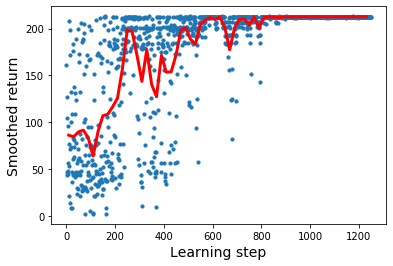

In [32]:
plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Smoothed return', fontsize=14)
x, y = ut.smooth_traj(r_traj[:,0], 1)
plt.scatter(x,y,s=10)
x, y = ut.smooth_traj(r_traj[:,0], 20)
plt.plot(x,y, color='red', lw=3)

plt.savefig(plot_dir+'return.png', dpi=200)

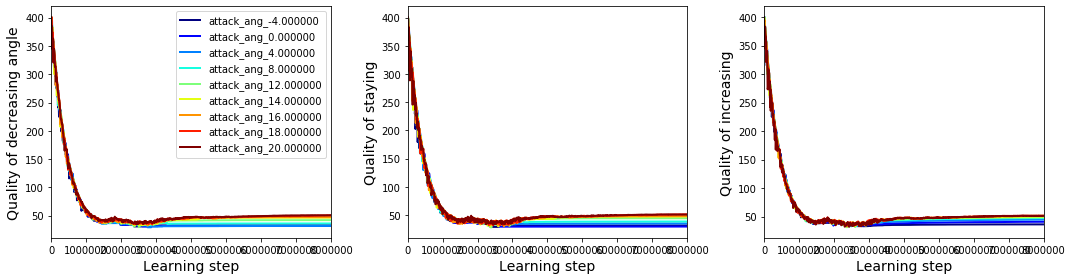

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
colors = plt.cm.jet(np.linspace(0,1,len(q_traj[0])))
states = range(0,len(q_traj[0]))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Quality of decreasing angle', fontsize=14)
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
ax1.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax1.plot(xs, q_traj[:,k,0], c=colors[k], label=s_labels[k], lw=2)
ax1.legend()

ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Quality of staying', fontsize=14)
ax2.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax2.plot(xs, q_traj[:,k,1], c=colors[k], label=s_labels[k], lw=2)

ax3.set_xlabel('Learning step', fontsize=14)
ax3.set_ylabel('Quality of increasing', fontsize=14)
ax3.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
for k in states:
    ax3.plot(xs, q_traj[:,k,2], c=colors[k], label=s_labels[k], lw=2)
    
plt.tight_layout()
plt.savefig(plot_dir+'qualities.png', dpi=200)